# 1. Discretize the state space

In [260]:
import numpy as np
from LSTM import LSTM
from System import Plant
from Policy import Estimator
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
np.random.seed(0)

c_resolution = 0.1 #unit: kW 
p_resolation = 3 #unit: kW
l_resolution = 2 #unit: kW
u_resolution = 1 # TODO
dt = 1/60 # hour
T  = 100
plant = Plant(dt)
estimator = Estimator()

c_dis = np.arange(start=0, stop=7.01, step=c_resolution) # TODO kW`h should has larger resolution
p_dis = np.arange(start=0, stop=15.01, step=p_resolation) 
l_dis = np.arange(start=0, stop=10.01, step=l_resolution)
u_dis = np.arange(start=-5, stop=5, step=u_resolution)

n = c_dis.shape[0] * p_dis.shape[0] * l_dis.shape[0]
print("Size of state space: {}".format(n))
print("Size of action space: {}".format(u_dis.shape[0]))

Size of state space: 2556
Size of action space: 5


# 2. Generate transition matrix

In [261]:
def close_idx(list, target):
    '''
    find closest index in list to target
    '''
    return np.argmin(np.abs(list - target))

def get_idx(p_idx, c_idx, l_idx):
    '''
    encode p_idx, c_idx, l_idx to a single integer
    '''
    return int(p_idx * c_dis.shape[0] * l_dis.shape[0] + 
            c_idx * l_dis.shape[0]                  +
            l_idx)
    
def get_pcl(idx):
    '''
    decode p, c, l from a single integer
    '''
    p_idx = idx // (c_dis.shape[0] * l_dis.shape[0])
    c_idx = (idx % (c_dis.shape[0] * l_dis.shape[0])) // l_dis.shape[0]
    l_idx = idx % l_dis.shape[0]
    return [p_dis[p_idx], c_dis[c_idx], l_dis[l_idx]]

def get_convex_combination(p, c, l):
    """Get convex combination given target state

    Returns:
        dict: dictionary of hit state and probability
    """
    
    hit_state_idx_list = {}
    
    def idx_prob(dis, p):
        p_close_idx = close_idx(dis, p)
        if p >= dis[-1]:
            p_left_idx = dis.shape[0] - 1
            p_right_idx = dis.shape[0] - 2
            p_left_prob = 1
            p_right_prob = 0
        elif p <= 0:
            p_left_idx = 0
            p_right_idx = 1
            p_left_prob = 1
            p_right_prob = 0
        elif p >= dis[p_close_idx]:
            p_left_idx = p_close_idx
            p_right_idx = p_close_idx + 1
            p_right_prob = (p - dis[p_close_idx]) / (dis[p_close_idx + 1] - dis[p_close_idx])
            p_left_prob = (dis[p_close_idx + 1] - p) / (dis[p_close_idx + 1] - dis[p_close_idx])
        elif p < dis[p_close_idx]:
            p_left_idx = p_close_idx - 1
            p_right_idx = p_close_idx
            p_right_prob = (p - dis[p_close_idx - 1]) / (dis[p_close_idx] - dis[p_close_idx - 1])
            p_left_prob = (dis[p_close_idx] - p) / (dis[p_close_idx] - dis[p_close_idx - 1])
        return [p_left_idx, p_right_idx, p_left_prob, p_right_prob]
    
    p_idx = np.zeros(2)
    p_prob = np.zeros(2)
    c_idx = np.zeros(2)
    c_prob = np.zeros(2)
    l_idx = np.zeros(2)
    l_prob = np.zeros(2)
    
    p_idx[0], p_idx[1], p_prob[0], p_prob[1] = idx_prob(p_dis, p)
    c_idx[0], c_idx[1], c_prob[0], c_prob[1] = idx_prob(c_dis, c)
    l_idx[0], l_idx[1], l_prob[0], l_prob[1] = idx_prob(l_dis, l)
    
    for i in range(2):
        for j in range(2):
            for k in range(2):
                hit_idx = get_idx(p_idx[i], c_idx[j], l_idx[k])
                hit_prob = p_prob[i] * c_prob[j] * l_prob[k]
                hit_state_idx_list[hit_idx] = hit_prob
    
    return hit_state_idx_list
    

Save P_trans dic (super large, takes much time):

In [262]:
# import pickle
# P_trans_file = open("data/P_trans.pkl", "wb")
# pickle.dump(P_trans, P_trans_file)
# P_trans_file.close()

# with open('data/P_trans.pkl', 'rb') as f:
#     P_trans = pickle.load(f)

Ensure the transition matrix is valid:

# 3. Dynamic programming

In [263]:
import torch

device = torch.device('cpu')

J = torch.tensor([get_pcl(i)[0] for i in range(n)], device=device).float()
Actions = torch.zeros(size=(T, n), device=device)
for t in tqdm(range(T-1, -1, -1)):
    J_update = torch.zeros_like(J)
    for i in (range(n)): 
        p, c, l = get_pcl(i)
        J_expect = torch.zeros(u_dis.shape[0])
        for u_idx, u in enumerate(u_dis):
            plant.reset(c, p, l)
            plant.step(u, l)
            hit_state_list = get_convex_combination(plant.p, plant.battery.c, plant.l)
            for hit_state, hit_prob in hit_state_list.items():
                J_expect[u_idx] += J[hit_state] * hit_prob
        J_update[i], Action_idx = torch.min(J_expect, dim=0)
        Actions[t][i] = int(Action_idx)
    J = J_update
print(get_pcl(int(torch.argmin(J))))
print(J)

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]

[0.0, 0.0, 0.0]
tensor([ 0.0000,  3.0000,  6.0000,  ..., 15.0000, 15.0000, 15.0000])


In [264]:
print(Actions[-50])

tensor([3., 2., 2.,  ..., 0., 0., 0.])


In [265]:
# print(J)
# print(torch.argmin(J))
# get_pcl(147)

In [266]:
# print(Actions.shape)
# import pickle
# P_trans_file = open("data/Action_table_v1.pkl", "wb")
# pickle.dump(Actions, P_trans_file)
# P_trans_file.close()


In [267]:
# import pickle
# with open('data/Action_table.pkl', 'rb') as f:
#     Actions = pickle.load(f)

# 4. Testing with real data

In [268]:
device = 'cpu'
Actions = Actions.to(device=device)

In [269]:
import pandas as pd

df = pd.read_csv('data.csv')  # read df from csv file

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H;%M:%S')
df = df.drop(columns=['Date', 'Time'])
df.set_index('Datetime', inplace=True)

print(df[:5])

                      Load
Datetime                  
2007-10-01 00:00:00  1.324
2007-10-01 00:01:00  1.320
2007-10-01 00:02:00  1.318
2007-10-01 00:03:00  1.320
2007-10-01 00:04:00  1.312


peak: 0, c: 0, load: 0
action: -1.0
current time: 2007-10-01 00:00:00
peak: 1.324, c: 0, load: 1.324
action: 0.9206826666666666
current time: 2007-10-01 00:01:00
peak: 2.240682666666667, c: 0.014730922666666667, load: 1.32
action: 1.335776142222222
current time: 2007-10-01 00:02:00
peak: 2.653776142222222, c: 0.036103340942222215, load: 1.318
action: 1.5245835526637035
current time: 2007-10-01 00:03:00
peak: 2.8445835526637033, c: 0.06049667778484147, load: 1.32
action: 1.6095445438742122
current time: 2007-10-01 00:04:00
peak: 2.9215445438742123, c: 0.08624939048682886, load: 1.3119999999999998
action: 1.652015097456972
current time: 2007-10-01 00:05:00
peak: 2.966015097456972, c: 0.11268163204614041, load: 1.314
action: 1.6704575712369885
current time: 2007-10-01 00:06:00
peak: 2.9864575712369876, c: 0.13940895318593222, load: 1.3159999999999998
action: 1.6778246524840668
current time: 2007-10-01 00:07:00
peak: 2.9958246524840666, c: 0.16625414762567728, load: 1.318
action: 1.6801016

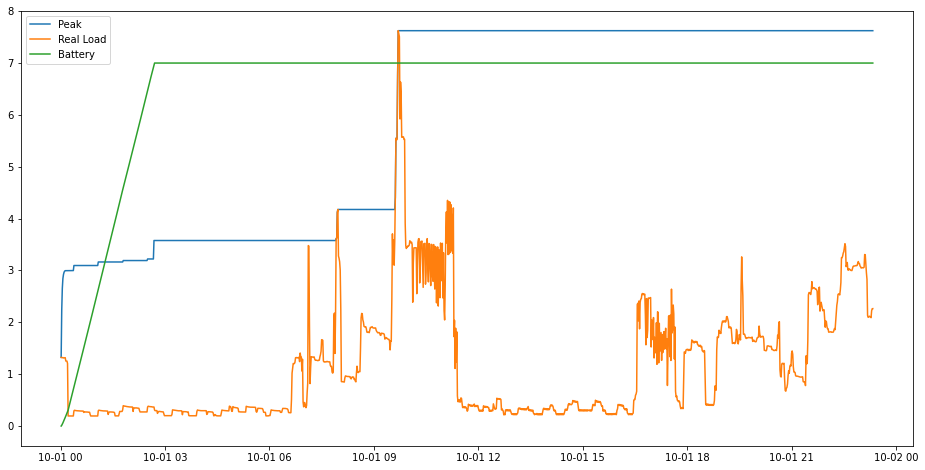

In [270]:
import matplotlib.pyplot as plt
import datetime

simu_time = T * dt # hour
simu_step = T * 14
cur_time = df.index[0] #2007-10-01 00:00:00 

peaks = []
loads = []
times = []
batteries = []

env = Plant(dt=dt)
p, c, l = env.reset(init_battery=0, init_peak=0, init_load=0)
p_pre = p
for i in range(simu_step):
    # state_idx = get_idx(close_idx(p_dis, p), close_idx(c_dis, c), close_idx(l_dis, l))
    # action_idx = int(Actions[i%T][state_idx].item())
    
    hit_state_list = get_convex_combination(p, c, l)
    u = 0
    for state_idx, state_prob in hit_state_list.items():
        action_idx = int(Actions[i%T][int(state_idx)].item())
        u += u_dis[action_idx] * state_prob
    
    print("peak: {}, c: {}, load: {}".format(p, c, l))
    print("action: {}".format(u))
    print("current time:", cur_time)
    print("=============================")
    
    real_load = df.loc[cur_time, 'Load']
    # p, c, l = env.step(u_dis[action_idx], real_load)
    p, c, l = env.step(u, real_load)
    
    cur_time += datetime.timedelta(hours=dt)
    times.append(cur_time)
    # peaks.append(l + u_dis[action_idx])
    peaks.append(p)
    loads.append(l)
    batteries.append(c)

fig, axs = plt.subplots(1, figsize=(16, 8))
axs.plot(times, peaks, label='Peak')
axs.plot(times, loads, label='Real Load')
axs.plot(times, batteries, label='Battery')
axs.legend()
plt.show()

In [ ]:
print(u_dis[int(Actions[i%T][get_idx(7,0,12)])])

T  = 360